<a href="https://colab.research.google.com/github/Vladislav-GitHub/DL-and-NLP-ITMO-course/blob/hw_4/NLP_4_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт данных

In [ ]:
!pip install contractions
!pip install -U spacy
!python3 -m spacy download en_core_web_sm
!pip install num2words
!pip install torchmetrics

In [ ]:
import contractions
import random
import re
import nltk
import spacy
import torch
import torch.nn as nn
import warnings
import numpy as np
import pandas as pd
import unicodedata as ucd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import islice
from nltk.probability import FreqDist
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
from matplotlib import rcParams
from collections import Counter
from string import punctuation
from num2words import num2words
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', 400)
rcParams['figure.figsize'] = 12, 9
nltk.download('punkt')
nltk.download('stopwords')
stopwords = stopwords.words('english')
punctuation = list(punctuation)

#Набор данных

In [ ]:
real_news = pd.read_csv("True.csv")
real_news['text'] = real_news['text'].apply(lambda x: ' '.join(x.split(' ')[5:]))
fake_news = pd.read_csv("Fake.csv")
real_news['label'] = 0
fake_news['label'] = 1
data = pd.concat([real_news, fake_news], ignore_index=True, axis=0)

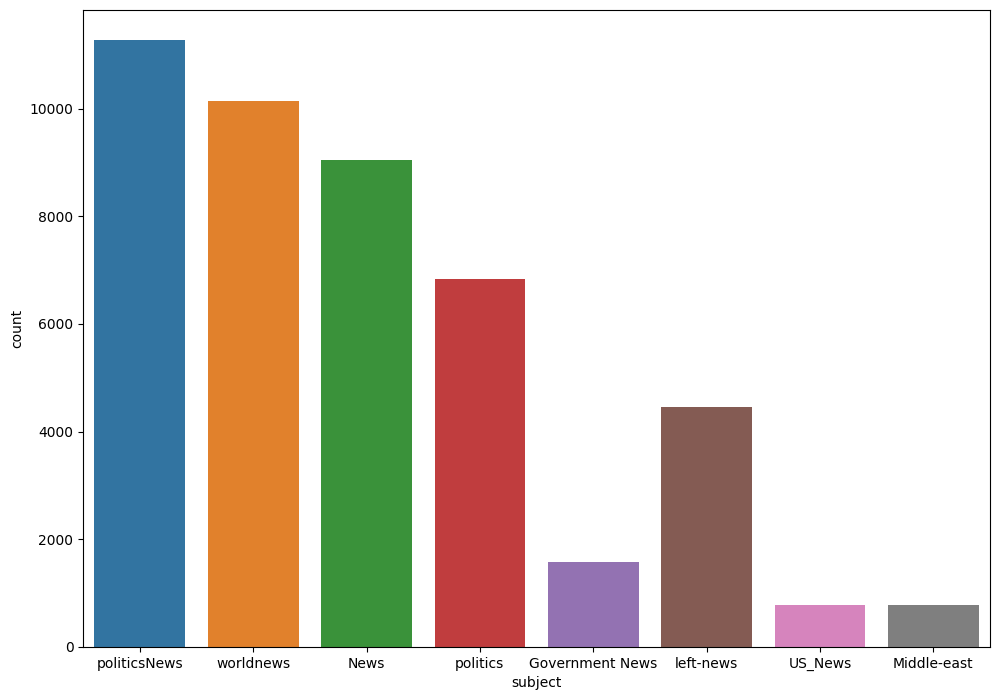

In [ ]:
sns.countplot(x="subject", data=data)
plt.show()

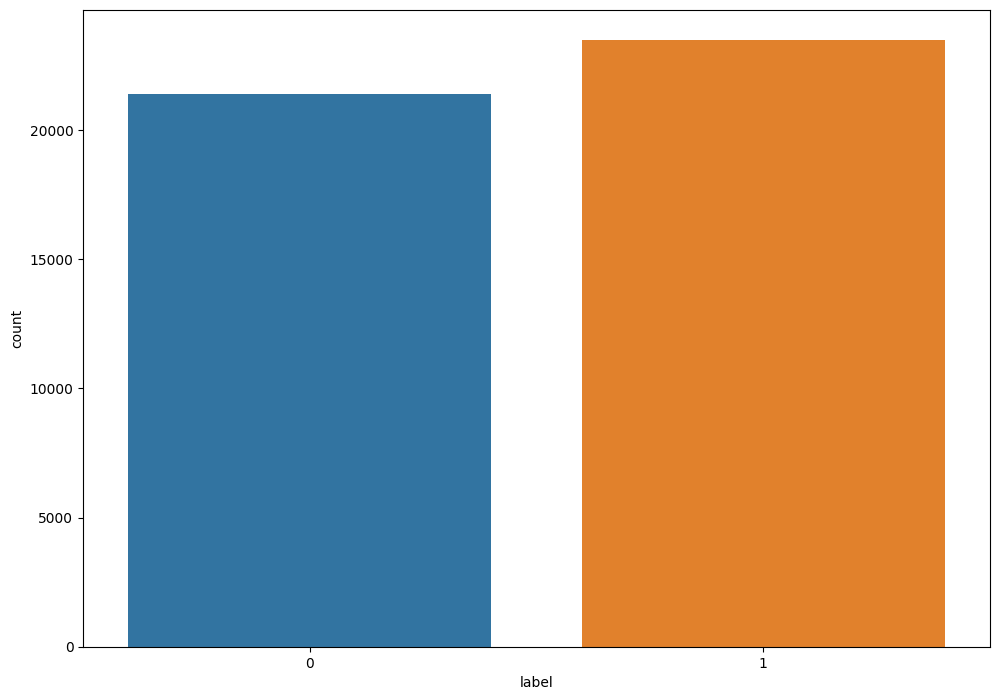

In [ ]:
sns.countplot(x="label", data=data)
plt.show()

#Предобработка данных

In [ ]:
class Preprocessor():
    def __init__(self, data):
        self.data = data
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def _normalize(self, text):
        """
        Нормализация текста
        """
        text = [ucd.normalize('NFKD', word).lower() for word in text]
        text = [re.sub(r'[^\w\s]', '', word) for word in text if word != '']
        text = [num2words(word, lang='eng') if word.isdigit() else word for word in text]
        text = ''.join([c for c in text if c not in punctuation])
        text = re.sub('[^a-z]', ' ', text)
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', text)
        text = re.sub(r'\b(?![Ia])\w\b', ' ', text)
        text = re.sub(r"(\d)+.", "\1", text)
        # text = re.sub(r"[\s]\s+", "", text)
        text = re.sub(r"", "", text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _tokenizer(self):
        self.data['cleaned_text'] = self.data['cleaned_text'].apply(lambda x: word_tokenize(x, language='english'))

    def _remove_stopwords(self):
        """
        Удаление стоп-слов из списка токенизированных слов
        """
        sw = stopwords.words('english')
        self.data['cleaned_text'] = self.data['cleaned_text'].apply(lambda x: [word for word in x if word not in sw])

    def _get_lemmatizer(self, token):
        doc = self.nlp(" ".join(token))
        return [token.lemma_ for token in doc]

    def preprocess(self):
        self.data['cleaned_text'] = self.data['text'].apply(lambda x: self._normalize(x))
        self._tokenizer()
        self._remove_stopwords()
        self.data['cleaned_text'] = self.data['cleaned_text'].apply(self._get_lemmatizer)
        return data

In [ ]:
preprocessor = Preprocessor(data)
data = preprocessor.preprocess()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['cleaned_text']], data['label'], test_size=0.4, shuffle=True, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=seed)
X_train['length'] = X_train['cleaned_text'].apply(lambda x: len(x))
X_train['length'].mean()

231.98010245749498

In [ ]:
X_train['cleaned_text'] = X_train['cleaned_text'].apply(lambda x: ' '.join(x))
X_valid['cleaned_text'] = X_valid['cleaned_text'].apply(lambda x: ' '.join(x))
X_test['cleaned_text'] = X_test['cleaned_text'].apply(lambda x: ' '.join(x))
X_train['tokens'] = X_train['cleaned_text'].apply(lambda x: word_tokenize(x, language='english'))

#Векторизация с паддингом

In [ ]:
w2v_model = Word2Vec(X_train['tokens'], window=5, min_count=1)
print(len(w2v_model.wv))

In [ ]:
w2v_model.wv.most_similar(positive=['trump', 'biden', 'obama'])

[('obamas', 0.6611693501472473),
 ('bush', 0.6357021927833557),
 ('protesterswa', 0.6101472973823547),
 ('dataor', 0.5758607983589172),
 ('penny', 0.5654822587966919),
 ('obamaobama', 0.5566176176071167),
 ('obamain', 0.5554772019386292),
 ('obamawe', 0.5536879301071167),
 ('datawe', 0.5521184802055359),
 ('trumps', 0.5473297834396362)]

In [ ]:
train_data = list(X_train['tokens'])
tokens = []

for token in tqdm(train_data):
  tokens.extend(token)
tokens_filtered = [word for word in tokens if word.isalnum()]
max_words = 10000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
tokens_filtered_top[:10]

  0%|          | 0/26938 [00:00<?, ?it/s]

['say',
 'trump',
 'would',
 'president',
 'people',
 'one',
 'state',
 'make',
 'we',
 'go']

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
print(len(vocabulary))

9999

In [ ]:
def text_to_sequence(text, maxlen):
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    result = [vocabulary[word] for word in tokens_filtered if word in vocabulary]
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [ ]:
max_len = 235
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(X_train["cleaned_text"])], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(X_test["cleaned_text"])], dtype=np.int32)
x_valid = np.array([text_to_sequence(text, max_len) for text in tqdm(X_valid["cleaned_text"])], dtype=np.int32)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

  0%|          | 0/26938 [00:00<?, ?it/s]

  0%|          | 0/5388 [00:00<?, ?it/s]

  0%|          | 0/12572 [00:00<?, ?it/s]

In [ ]:
# Сохранение numpy массивов
with open('test.npy', 'wb') as f:
    np.save(f, x_train)
    np.save(f, x_valid)
    np.save(f, x_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

#Тренировка данных

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).float()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
class ConvNewsClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, out_channel=30):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, 1)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [ ]:
class LSTMNewsClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hidden_dim=64, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [ ]:
batch_size = 512
train_dataset = TextDataset(x_train, y_train)
valid_dataset = TextDataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model_cnn = ConvNewsClassifier()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion_cnn = nn.BCEWithLogitsLoss()
f1_cnn = F1Score(task="binary")

In [ ]:
model_lstm = LSTMNewsClassifier()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion_lstm = nn.BCEWithLogitsLoss()
f1_lstm = F1Score(task="binary")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def train_model(model, n_epochs, optimizer, criterion, metrics):
    model.to(device)
    metrics.to(device)

    history = {
    'train_losses': [],
    'train_metrics': [],
    'valid_losses': [],
    'valid_metrcis': []
    }

    for epoch in range(n_epochs):
        train_losses_iter = []
        train_metrics_iter = []
        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), target)
            train_losses_iter.append(loss.float().item())
            train_metrics_iter.append(metrics((torch.sigmoid(out).squeeze() > 0.5).long(), target).item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        history['train_losses'].append(np.mean(train_losses_iter))
        history['train_metrics'].append(np.mean(train_metrics_iter))

        valid_losses_iter = []
        valid_metrics_iter = []
        model.eval()

        for i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), target)
            valid_losses_iter.append(loss.float().item())
            valid_metrics_iter.append(metrics((torch.sigmoid(out).squeeze() > 0.5).long(), target).item())

        history['valid_losses'].append(np.mean(valid_losses_iter))
        history['valid_metrcis'].append(np.mean(valid_metrics_iter))

        print(f'train: loss {history["train_losses"][-1]:.4f}\n'
        f'train: f1-score {history["train_metrics"][-1]:.4f}\n'
        f'valid: loss {history["valid_losses"][-1]:.4f}\n'
        f'valid: f1-score {history["valid_metrcis"][-1]:.4f}')
        print(f'{"-"*35}')
        print()

    return history, model

In [ ]:
history_cnn, model_cnn = train_model(model_cnn, 15, optimizer_cnn, criterion_cnn, f1_cnn)

In [ ]:
history_lstm, model_lstm = train_model(model_lstm, 15, optimizer_lstm, criterion_lstm, f1_lstm)

In [ ]:
def visualize_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['valid_losses'], label='Valid Loss', color='red')
    ax1.set_title('Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_metrics'], label='Train Metrics', color='blue')
    ax2.plot(history['valid_metrcis'], label='Valid Metrics', color='red')
    ax2.set_title('Metrics')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_history(history_cnn)

In [ ]:
visualize_history(history_lstm)

#Тестирование

In [ ]:
batch_size = 512
test_dataset = TextDataset(x_test, y_test)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_metrics_cnn = []
test_metrics_lstm = []
model_cnn.eval()
model_lstm.eval()

for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        out_cnn = model_cnn(data)
        out_lstm = model_lstm(data)
        test_metrics_cnn.append(f1_cnn((torch.sigmoid(out_cnn).squeeze() > 0.5).long(), target).item())
        test_metrics_lstm.append(f1_lstm((torch.sigmoid(out_lstm).squeeze() > 0.5).long(), target).item())
print(np.mean(test_metrics_cnn))
print(test_metrics_lstm)

1.0
[1.0, 1.0, 0.9982110857963562, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980430603027344, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998171865940094, 0.9981784820556641, 1.0, 1.0, 0.9982964396476746, 1.0, 1.0, 1.0, 0.9962121248245239, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980276226997375, 1.0, 1.0, 0.9982300996780396, 1.0, 1.0, 0.998171865940094, 1.0, 1.0, 1.0, 1.0, 0.9980806112289429, 1.0, 1.0, 1.0, 1.0]
